In [1]:
import numpy as np
import os
import torch
import trimesh
import math
import scipy.io as sio
import copy
import open3d as o3d
import matplotlib.pyplot as plt
from transforms3d.euler import euler2mat
from core.models.utils.align import ExpSO3
os.environ["PYOPENGL_PLATFORM"] = "osmesa"
import pyrender
from pytorch3d.ops.knn import knn_gather, knn_points

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2023-06-02 19:24:55,928 - acceleratesupport - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


In [2]:
def generate_mesh(point, color1, color2=None, mask=0, weight=0, split=False):
    sm = trimesh.creation.uv_sphere(radius=0.01, count=[6,6])
    nv = sm.vertices.shape[0]
    vtx, faces, tex = [], [], []
    print(point.shape[0])
    
    for i in range(point.shape[0]):
        vtx.append(sm.vertices.copy() + point[i])
        faces.append(sm.faces.copy() + i * nv)
        if not split:
            tex.append(np.ones_like(vtx[-1]) * color1)
        else:
            if type(mask) != int:
                if mask[0,i] < mask[1,i]:
                    tex.append(np.ones_like(vtx[-1]) * color2)
                else:
                    tex.append(np.ones_like(vtx[-1]) * color1)
            if type(weight) != int:
                color = color1 * weight[i] + color2 * (1 - weight[i])
                tex.append(np.ones_like(vtx[-1]) * color * 0.99)
    vtx = np.concatenate(vtx, axis=0)
    faces = np.concatenate(faces, axis=0)
    tex = np.concatenate(tex, axis=0)
    mesh = trimesh.Trimesh(vertices=vtx, faces=faces, vertex_colors=tex)
    return mesh

def binary_split(x):
        B, P, T, N, _ = x.shape
        exclude = [[list(range(j)), list(range(j+1, T))]for j in range(T)]
        exclude = [exclude[j][0] + exclude[j][1] for j in range(T)]  # T,T-1
        others = torch.stack(
            [x.unsqueeze(2)[:, :, :, exclude[j], :, :3] for j in range(T)],
            dim=2)  # B,P,T,T-1,N,3
        others = others.reshape(B*P*T, -1, 3)  # BPT,(T-1)N,3
        query = x.reshape(B*P*T, N, -1)[:, :, :3]  # BPT,N,3
        return query, others

In [140]:
b,t,p = 1,0,1
path = 'log/cadex_pm_laptop_pcl/weight/'
r = pyrender.OffscreenRenderer(480, 480)
data =torch.load(path + 'query_501.pt').detach().cpu()
data = data.detach().cpu().reshape(6,2,4,2048,3)
mask = torch.load(path + 'weights_501.pt').detach().cpu()
mask = mask.reshape(6,2,4,2048)
joint_trans = torch.load(path + 'c_trans_501.pt').detach().cpu()
joint_direction = torch.load(path + 'c_axis_501.pt').detach().cpu()

In [141]:
from core.models.utils.pyrender_helper import rodrigues_rotation_formula
transform_a = np.asarray([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0.5],
    [0, 0, 0, 1]
    ], dtype=np.float32)
a = trimesh.creation.cone(0.04, 0.05, transform=transform_a)
c = trimesh.creation.cylinder(0.02, height=1)
joint_mesh = trimesh.util.concatenate(a,c)
transform_joint = np.asarray([
    [1, 0, 0, joint_trans[b,0,0]],
    [0, 1, 0, joint_trans[b,0,1]],
    [0, 0, 1, joint_trans[b,0,2]],
    [0, 0, 0, 1]
    ], dtype=np.float32)
R = rodrigues_rotation_formula(np.array([0,0,1]), joint_direction[b,0,:3]/np.linalg.norm(joint_direction[b,0,:3]))
transform_joint[:3,:3] = R
joint_mesh.apply_transform(transform_joint)
joint_mesh.visual.vertex_colors = np.array([0.1,0.1,0.1,1])

#scene.add(pyrender.Mesh.from_trimesh(joint_mesh, material=None))

In [142]:
x, y = binary_split(data)
x_nn = knn_points(x, y,  norm=2, K=1)
cham_x = x_nn.dists[..., 0]  # (N, P1)
cham_x = 1 - torch.exp(-1000 * cham_x)
cham_x = cham_x.reshape(6,2,4,-1)


for i in range(data.shape[0]):
    cham_min, cham_max = cham_x[i].flatten().min(), cham_x[i].flatten().max()
    cham_range = cham_max - cham_min
    cham_x[i] = (cham_x[i] - cham_min) / cham_range
cham_x = cham_x.cpu().numpy()


In [143]:
'''
mesh_p0 = generate_mesh(
    data[b,p,:,:].reshape(-1,3).numpy(),
    color1=np.array([0.5,1,0.5]),
    color2=np.array([1,0.5,0.5]),
    mask=cham_x[b].reshape(2,-1),
    split=True)
'''
flame1, flame2 = 0, 1
mesh_mask = generate_mesh(
    data[b,p,[flame1, flame2],:].reshape(-1,3).numpy(),
    color2=np.array([0.5,1,0.5]),
    color1=np.array([1,0.5,0.5]),
    #weight=cham_x[b,p].flatten(),
    mask=mask[b].reshape(-1, 4*2048),
    split=True)

mesh_weight = generate_mesh(
    data[b,p,[flame1, flame2],:].reshape(-1,3).numpy(),
    #distance
    color2=np.array([55/255,55/255,132/255]),
    color1=np.array([1,69/255,0]),
    weight=cham_x[b,p,[flame1, flame2]].flatten(),
    #segmentation
    #color2=np.array([1,1,1]),
    #color1=np.array([0.1,0.1,0.1]),
    #weight=mask[b,p,[flame1, flame2]].flatten().numpy(),
    #mask=mask[b].reshape(-1, 4*1024),
    split=True)

threshold = threshold = cham_x[b,-1].flatten().mean()
threshold_mask = cham_x[b,-1] > threshold.flatten()
threshold_mask = np.stack([~threshold_mask, threshold_mask], axis=0)
mesh_threshold = generate_mesh(
    data[b,p,:,:].reshape(-1,3).numpy(),
    color1=np.array([1,0.5,0.5]),
    color2=np.array([0.5,1,0.5]),
    #weight=cham_x[b,p].flatten(),
    mask=threshold_mask.reshape(-1, 4*2048),
    split=True)

R = euler2mat(0*np.pi, 0.1*np.pi, -0.1*np.pi, "rzyx")
#R = euler2mat(0.5*np.pi, 0.26*np.pi, -0.3*np.pi, "rzyx")
camera_pose = np.eye(4)
camera_pose[:3, :3] = R
#camera_pose[:3, 3] = np.array([-0.,0.,1.3])
camera_pose[:3, 3] = np.array([-0.2,0.,2])
camera_pose[:3, 3:4] = R @ camera_pose[:3, 3:4]
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3, aspectRatio=1.0,)
light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=4.0)

scene_mask = pyrender.Scene()
scene_mask.add(pyrender.Mesh.from_trimesh(mesh_mask, material=None))
scene_mask.add(camera, pose=camera_pose)
scene_mask.add(pyrender.Mesh.from_trimesh(joint_mesh, material=None))
scene_mask.add(light, pose=camera_pose)
color_mask, depth = r.render(scene_mask)

scene_weight = pyrender.Scene()
scene_weight.add(pyrender.Mesh.from_trimesh(mesh_weight, material=None))
scene_weight.add(camera, pose=camera_pose)
scene_weight.add(pyrender.Mesh.from_trimesh(joint_mesh, material=None))
scene_weight.add(light, pose=camera_pose)
color_weight, depth = r.render(scene_weight)

scene_threshold = pyrender.Scene()
scene_threshold.add(pyrender.Mesh.from_trimesh(mesh_threshold, material=None))
scene_threshold.add(pyrender.Mesh.from_trimesh(joint_mesh, material=None))
scene_threshold.add(camera, pose=camera_pose)
scene_threshold.add(light, pose=camera_pose)
color_threshold, depth = r.render(scene_threshold)

4096
4096
8192


(-0.5, 479.5, 479.5, -0.5)

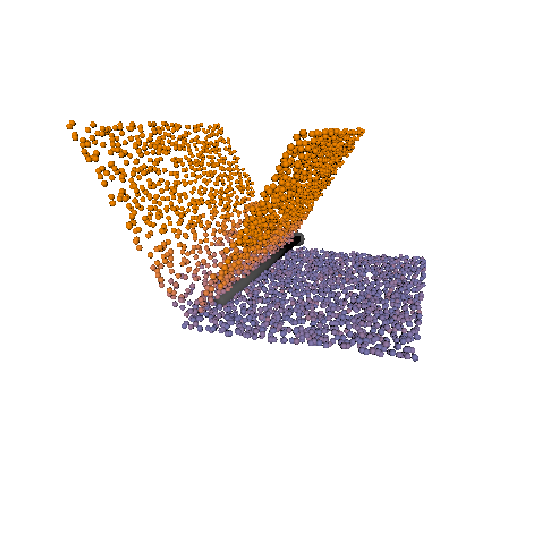

In [144]:
plt.figure(figsize=(10, 10))
plt.subplot(1,1,1)
#plt.imshow(color_mask)
#plt.axis('off')
#plt.subplot(1,2,1)
plt.imshow(color_weight)
plt.axis('off')


In [129]:
cham_x[b,p,[flame1, flame2]].shape

(2, 2048)

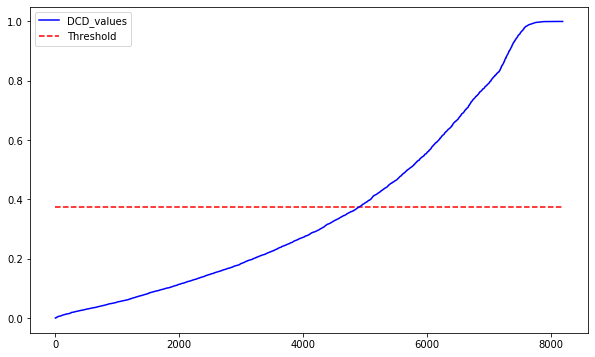

In [13]:
dis = cham_x[b,p].flatten()
dis.sort()

plt.figure(figsize=(10,6))
img = plt.plot(dis, label="DCD_values", color="blue")
img = plt.hlines([dis.mean()], 0, dis.shape[0], "red", linestyles='dashed', label="Threshold") 
plt.legend()
plt.show(img)

In [4]:
rotation_list = []
for i in range(309):
    rand_vec = 2 * torch.rand(1, 3) - 1
    rand_vec[:,0] = 0
    rand_vec[:,2] = 0
    rand_vec = ExpSO3(math.pi * rand_vec).unsqueeze(1).numpy()#1,1,3,3

    camera_list = np.random.rand(11, 3)
    camera_list  =  2 * camera_list / np.linalg.norm(camera_list, axis=-1, keepdims=True)
    camera_list[:,1] = np.abs(camera_list[:,1])

    instance={'rotation': rand_vec, 'camera': camera_list}
    rotation_list.append(instance)

In [5]:
np.save('/nhome/yuchen_che/rotation_camera/test/flip_phone.npy', rotation_list)

In [5]:
test_rotation = np.load('/nhome/yuchen_che/rotation_camera/train/basket&bucket.npy', allow_pickle=True)

In [27]:
test_rotation[0]['rotation'].shape

(1, 1, 3, 3)

In [9]:
mat = sio.loadmat('resource/data/partMobility/enhance_data/train/washing_machine/split_train_fps_1_0001_1.mat')['data'][0]

In [13]:
mat['input'][0].shape

(2048, 11, 6)

In [2]:


c_iou, c_o, c_d, c_e = 0.8906199906134974,4.904772314708063,0.06755429083902029,0.014212732041074384,
e_iou, e_o, e_d, e_e = 0.8148251193000365,3.301867821137588,0.08694913650446749,0.010174669781105315,
l_iou, l_o, l_d, l_e = 0.9608816151220279,0.5041846300740686,0.02351309221943847,0.017954434158804152,


c_i, e_i, l_i = 1705, 517, 3091

iou = (c_i*c_iou + e_i*e_iou + l_i*l_iou) / (c_i + e_i + l_i)
o = (c_i*c_o + e_i*e_o + l_i*l_o) / (c_i + e_i + l_i)
d = (c_i*c_d + e_i*e_d + l_i*l_d) / (c_i + e_i + l_i)
e = (c_i*c_e + e_i*e_e + l_i*l_e) / (c_i + e_i + l_i)

print(iou, o, d, e)

0.9241213519699455 2.1886198290352574 0.043819261717226346 0.015996643777851857
